### NEE calculated using USTAR CUT / VUT thresholds for USNE-1 maize-soybean site
#### Years 2015 - 2022

In [44]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import preprocessing
import math

In [45]:
neeJDR = pd.read_csv('datasets/extractedUSNEE_VUT_REF_NIGHT_SD.csv')

nee_pearson = pd.read_csv('datasets/extractedUSNEE_CUT_05_NIGHT.csv')
kmeans = pd.read_csv('datasets/extractedNEE_CUT_REF_NIGHT.csv')

jsd_y = neeJDR['NEE'].copy()

pearson_nee = nee_pearson['NEE'].copy()

kmeans_y = kmeans['NEE'].copy()

In [46]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)
    x = x.drop(['DATE'], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True)
df_irr = to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True)
df_cool = to_pd(datasets['cool_temp_maize_soybean'], True, True)

# NEE = GPP - ER:
#GPP = GROSS PRIMARY PRODUCTION (TOTAL C INTAKE) 
#ER = total C uptake =  ECO_RH + ECO_RA =  autotrophic + heterotrophic respiration 
#NPP = GPP + ECO_RA
df_dry['NEE'] = df_dry['ECO_NPP'] - df_dry['ECO_RH']
df_irr['NEE'] = df_irr['ECO_NPP'] - df_irr['ECO_RH']
df_cool['NEE'] = df_cool['ECO_NPP'] - df_cool['ECO_RH']

df= pd.concat([df_dry, df_irr, df_cool])
y = df['NEE'].copy()
#y = df[target].copy()
#df = df.drop(target, axis=1)

In [47]:
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

### NEE calculated using PR ecosys , (Gross primary production - Ecosystem respiration)
#### Suggestion : Autotrophic respiration + Net prime productivity?

In [48]:
# NEE = GPP - ER:
#GPP = GROSS PRIMARY PRODUCTION (TOTAL C INTAKE) 
#ER = total C uptake =  ECO_RH + ECO_RA =  autotrophic + heterotrophic respiration 
df_irr['NEE'] = df_irr['ECO_GPP'] - (df_irr['ECO_RH'] + df_irr['ECO_RA'])

# NEE = NPP + RH?
df_irr['NEE1'] = df_irr['ECO_NPP'] - df_irr['ECO_RH']
y = df_irr['NEE'].copy()
y1 = df_irr['NEE1'].copy()

In [40]:
def plot_against_time(eco_nee : pd.Series, obs_nee : pd.Series, title: str = 'NEE by time of the year' , xlabel: str = 'Procedural' , ylabel: str = 'Eddy Covariance'):
    dates = np.arange(0, len(eco_nee))

    # Define the two NEE datasets
    nee_procedural = eco_nee
    nee_eddy_covariance = obs_nee

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(dates, nee_procedural, label= xlabel, color='blue')
    ax.plot(dates, nee_eddy_covariance, label= ylabel, color='red')

    # Add axis labels and legend
    ax.set_xlabel('Samples')
    ax.set_ylabel('NEE')
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()

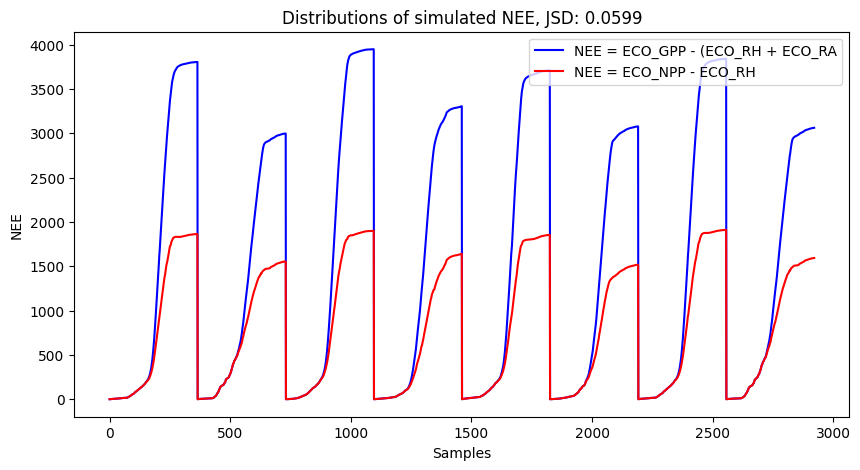

In [22]:
plot_against_time(y, y1,  'Distributions of simulated NEE, JSD: ' + "{:.4f}".format(jensen_shannon_distance(y,y1)), 'NEE = ECO_GPP - (ECO_RH + ECO_RA', 'NEE = ECO_NPP - ECO_RH')

In [42]:
kmeans_y

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
4379    0.004148
4380    0.002898
4381    0.002733
4382    0.001665
4383    0.020576
Name: NEE, Length: 4384, dtype: float64

In [43]:
jsd_y

0       0.244164
1       0.072773
2       0.633717
3       0.128690
4       0.938346
          ...   
2187    0.411845
2188    0.046652
2189    0.121735
2190    2.258270
2191    6.183050
Name: NEE, Length: 2192, dtype: float64

In [49]:
y = y[:2192]
y1 = y1[:2192]
y_norm = preprocessing.normalize([y])
y1_norm = preprocessing.normalize([y1])

jsd_norm = preprocessing.normalize([jsd_y])

pearson_norm = preprocessing.normalize([pearson_nee])

kmeans_norm = preprocessing.normalize([kmeans_y])


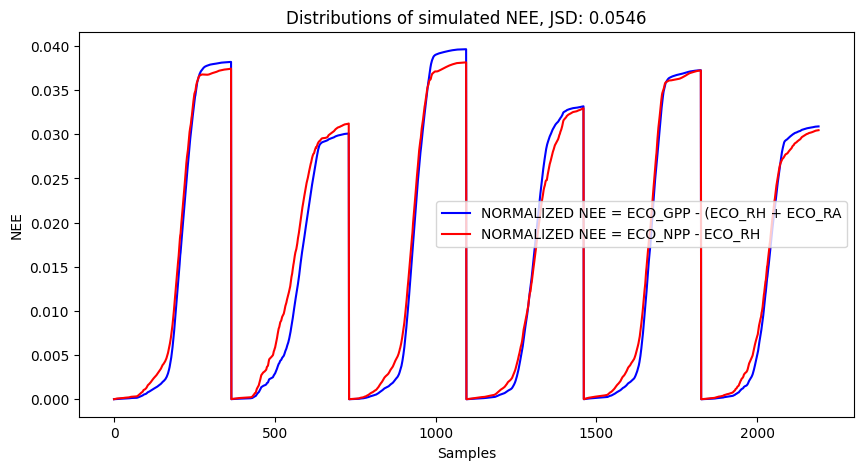

In [24]:
plot_against_time(y_norm[0],y1_norm[0],  'Distributions of simulated NEE, JSD: ' + "{:.4f}".format(jensen_shannon_distance(y_norm[0],y1_norm[0])), 'NORMALIZED NEE = ECO_GPP - (ECO_RH + ECO_RA', 'NORMALIZED NEE = ECO_NPP - ECO_RH')

### unscaled ecosys nee vs observed usne nee

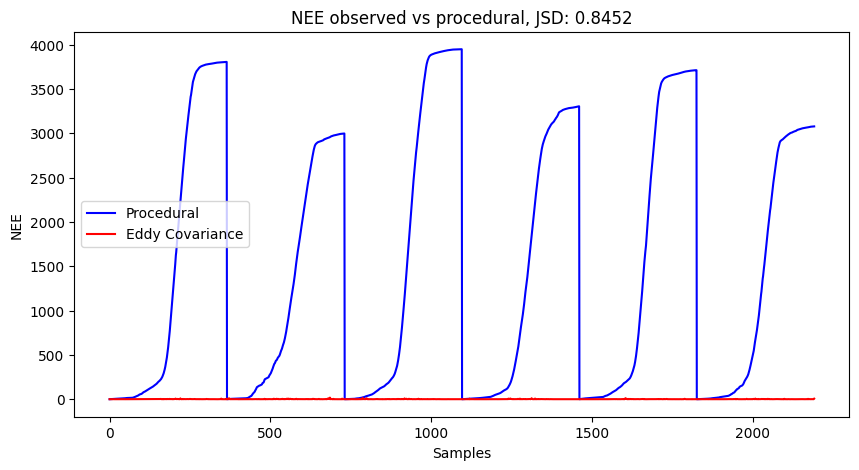

In [25]:
plot_against_time(y, usne_y, 'NEE observed vs procedural, JSD: ' + "{:.4f}".format(jensen_shannon_distance(y, usne_y)))

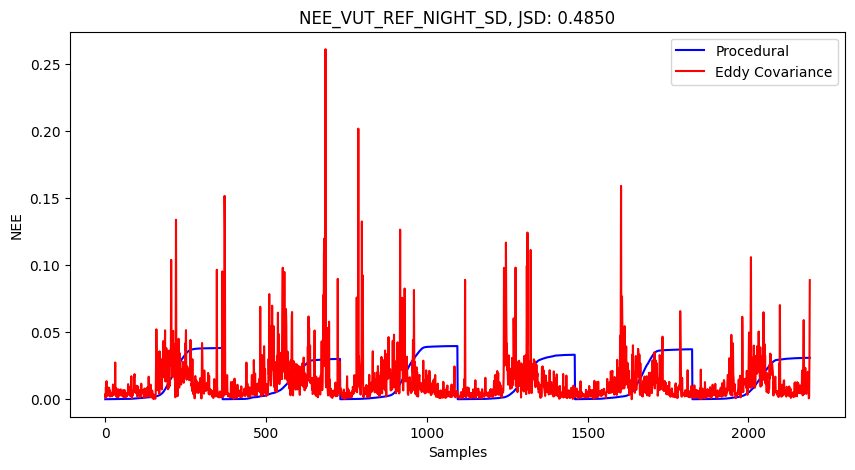

In [26]:
plot_against_time(y_norm[0], usne_norm[0], "NEE_VUT_REF_NIGHT_SD, JSD: " + "{:.4f}".format(jensen_shannon_distance(y_norm[0], usne_norm[0])))

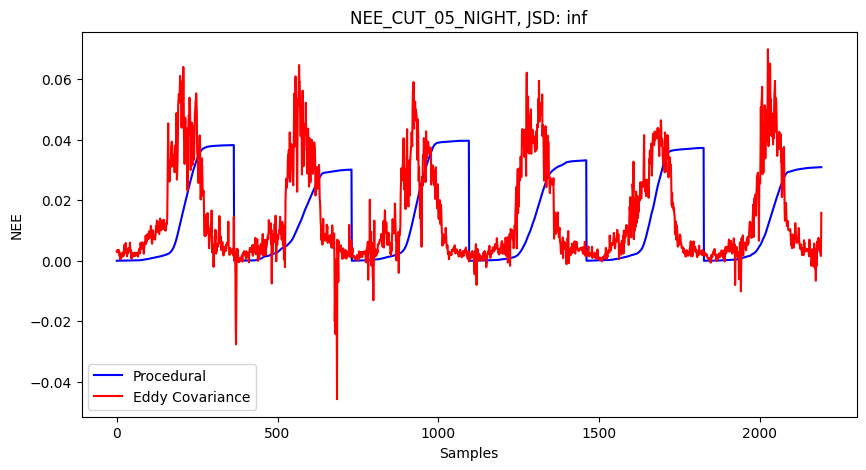

In [27]:
plot_against_time(y_norm[0], pearson_norm[0], "NEE_CUT_05_NIGHT, JSD: " + "{:.4f}".format(jensen_shannon_distance(y_norm[0], pearson_norm[0])))

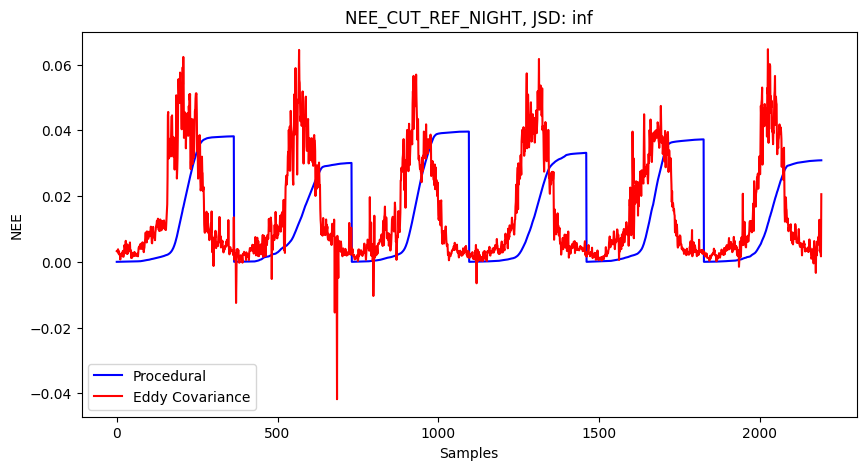

In [50]:
plot_against_time(y_norm[0], kmeans_norm[0], "NEE_CUT_REF_NIGHT, JSD: " + "{:.4f}".format(jensen_shannon_distance(y_norm[0], kmeans_norm[0])))